# Project 2- H5N1 Outbreak Prediction (Classification Model)

### *Research Question:*

#### Did a H5N1 outbreak occur at a specific location and time?

In [1002]:
# Initial imports
import pandas as pd
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
# Needed for decision tree visualization
import pydotplus
from IPython.display import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler


# Data Preparation & Cleaning

In [1003]:
# Read the datasets

wildbirds = pd.read_csv("../Data/hpai-wild-birds.csv")
wildbirds = wildbirds.rename(columns={'Date Detected': 'Outbreak Date'})
wildbirds_df = wildbirds[wildbirds['HPAI Strain'].str.contains('H5N1', na=False)]
wildbirds_df.head()

,State,County,Collection Date,Outbreak Date,HPAI Strain,Bird Species,WOAH Classification,Sampling Method,Submitting Agency
0,Alabama,Limestone,2/5/2022,2/23/2022,EA H5N1,American wigeon,Wild bird,Hunter harvest,NWDP
1,Alabama,Montgomery,10/29/2022,11/7/2022,EA/AM H5N1,Black vulture,Wild bird,Morbidity/Mortality,NWDP
2,Alabama,Montgomery,10/29/2022,11/7/2022,EA/AM H5N1,Black vulture,Wild bird,Morbidity/Mortality,NWDP
3,Alabama,Montgomery,10/29/2022,11/7/2022,EA/AM H5N1,Black vulture,Wild bird,Morbidity/Mortality,NWDP
4,Alabama,Montgomery,10/29/2022,11/7/2022,EA/AM H5N1,Black vulture,Wild bird,Morbidity/Mortality,NWDP


In [1004]:
# Clean the dataset by dropping unimportant columns.

wildbirds_df = wildbirds_df.drop(columns = ['Submitting Agency','Sampling Method','Collection Date'])
#wildbirds_df=wildbirds_df.dropna(subset='Outbreak Date')
wildbirds_df.head()

,State,County,Outbreak Date,HPAI Strain,Bird Species,WOAH Classification
0,Alabama,Limestone,2/23/2022,EA H5N1,American wigeon,Wild bird
1,Alabama,Montgomery,11/7/2022,EA/AM H5N1,Black vulture,Wild bird
2,Alabama,Montgomery,11/7/2022,EA/AM H5N1,Black vulture,Wild bird
3,Alabama,Montgomery,11/7/2022,EA/AM H5N1,Black vulture,Wild bird
4,Alabama,Montgomery,11/7/2022,EA/AM H5N1,Black vulture,Wild bird


In [1005]:
# Function to convert Date to Day, Month and Year

def convert_date(date):
    return pd.Series([date.year, date.month, date.day], index=["year", "month", "day"])


In [1006]:
wildbirds_df["Outbreak Date"] = pd.to_datetime(wildbirds_df["Outbreak Date"],errors='coerce')
wildbirds_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9937 entries, 0 to 11624
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   State                9937 non-null   object        
 1   County               9937 non-null   object        
 2   Outbreak Date        9914 non-null   datetime64[ns]
 3   HPAI Strain          9937 non-null   object        
 4   Bird Species         9937 non-null   object        
 5   WOAH Classification  9937 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 543.4+ KB


In [1007]:
# Convert Wild life Outbreak date to Day, Year and Month

#wildbirds_df[['Year','Month','Day']]=wildbirds_df['Outbreak Date'].apply(convert_date)
wildbirds_df.head()

,State,County,Outbreak Date,HPAI Strain,Bird Species,WOAH Classification
0,Alabama,Limestone,2022-02-23,EA H5N1,American wigeon,Wild bird
1,Alabama,Montgomery,2022-11-07,EA/AM H5N1,Black vulture,Wild bird
2,Alabama,Montgomery,2022-11-07,EA/AM H5N1,Black vulture,Wild bird
3,Alabama,Montgomery,2022-11-07,EA/AM H5N1,Black vulture,Wild bird
4,Alabama,Montgomery,2022-11-07,EA/AM H5N1,Black vulture,Wild bird


In [1008]:
# Read US counties dataset
us_county_fips=pd.read_csv("../Data/US_Counties.csv")
us_county_fips=us_county_fips.rename(columns={'state_name':'State',"county":"County","county_fips":"FIPS Code","lat":"Latitude","lng":"Longitude"})
us_county_fips=us_county_fips.drop(columns=['state_id','population'])

us_county_fips.head()

,State,County,FIPS Code,Latitude,Longitude
0,Alabama,Autauga,1001,32.5349,-86.6427
1,Alabama,Baldwin,1003,30.7277,-87.7226
2,Alabama,Barbour,1005,31.8696,-85.3932
3,Alabama,Bibb,1007,32.9986,-87.1265
4,Alabama,Blount,1009,33.9809,-86.5674


In [1009]:
us_county_fips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3144 entries, 0 to 3143
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   State      3144 non-null   object 
 1   County     3144 non-null   object 
 2   FIPS Code  3144 non-null   int64  
 3   Latitude   3144 non-null   float64
 4   Longitude  3144 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 122.9+ KB


In [1010]:
# Read the weather dataset for adding temperature and Precipitation features

weather_df=pd.read_csv("../Data/weather_cleaned.csv")
weather_df.head()

,State,County,Temp,Precipitation
0,Alabama,Autauga,65.9,52.43
1,Alabama,Baldwin,68.7,60.71
2,Alabama,Barbour,66.4,55.97
3,Alabama,Bibb,64.5,46.88
4,Alabama,Blount,63.1,47.63


In [1011]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107 entries, 0 to 3106
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   State          3107 non-null   object 
 1   County         3107 non-null   object 
 2   Temp           3107 non-null   float64
 3   Precipitation  3107 non-null   float64
dtypes: float64(2), object(2)
memory usage: 97.2+ KB


In [1012]:
# Reading the mammals outbreak datasets
mammal_df = pd.read_csv("../Data/HPAI Detections in Mammals.csv")
mammal_df = mammal_df.rename(columns={'Date Detected':'Outbreak Date','Species':'Mammal Species'})
#mammal_df = mammal_df[mammal_df['HPAI Strain'].str.contains('H5N1', na=False)]
mammal_df["Outbreak Date"] = pd.to_datetime(mammal_df["Outbreak Date"],errors='coerce')
mammal_df=mammal_df.drop(columns=['Date Collected'])
mammal_df.head()

,State,County,Outbreak Date,HPAI Strain,Mammal Species
0,Oregon,Multnomah,2025-02-10,EA H5N1,Domestic cat
1,Montana,Flathead,2025-02-10,EA AM H5N1,Domestic cat
2,California,San Mateo,2025-02-05,EA H5,Domestic cat
3,Colorado,Douglas,2025-01-31,EA H5N1,Domestic cat
4,California,Contra Costa,2025-01-24,EA H5,Domestic cat


In [1013]:
# Read mammal df data types
mammal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   State           493 non-null    object        
 1   County          493 non-null    object        
 2   Outbreak Date   493 non-null    datetime64[ns]
 3   HPAI Strain     493 non-null    object        
 4   Mammal Species  493 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 19.4+ KB


In [1014]:

# Reading he backyardflock datasets

backyardflock = pd.read_csv("../Data/backyard_flock_old.csv")
backyardflock = backyardflock.rename(columns={'Outbreak Date': 'Outbreak Date'})
backyardflock["Outbreak Date"] = pd.to_datetime(backyardflock["Outbreak Date"],errors='coerce')
#backyardflock=backyardflock.drop(columns=['FullGeoName','FIPS Codes'])
backyardflock.head()

,County,State,Outbreak Date,Flock Type,Flock Size
0,Ottawa,Michigan,2024-12-31,Commercial Turkey Meat Bird,29400
1,Riverside,California,2024-12-31,Commercial Table Egg Layer,181300
2,Spartanburg,South Carolina,2024-12-31,Commercial Upland Gamebird Producer,920
3,Butte,California,2024-12-31,WOAH Non-Poultry,70
4,Miner,South Dakota,2024-12-31,WOAH Poultry,1500


In [1015]:
backyardflock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1554 entries, 0 to 1553
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   County         1554 non-null   object        
 1   State          1554 non-null   object        
 2   Outbreak Date  1554 non-null   datetime64[ns]
 3   Flock Type     1554 non-null   object        
 4   Flock Size     1554 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 60.8+ KB


In [1016]:
# Combine us county fips df with wild birds

merge_df1=wildbirds_df.merge(us_county_fips,on=['State','County'], how='outer')
#merge_df1=merge_df1.merge(bird_migrate_df,on=['Month','Day','Year'], how='outer')
merge_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11935 entries, 0 to 11934
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   State                11935 non-null  object        
 1   County               11935 non-null  object        
 2   Outbreak Date        9935 non-null   datetime64[ns]
 3   HPAI Strain          9958 non-null   object        
 4   Bird Species         9958 non-null   object        
 5   WOAH Classification  9958 non-null   object        
 6   FIPS Code            11829 non-null  float64       
 7   Latitude             11829 non-null  float64       
 8   Longitude            11829 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 839.3+ KB


In [1017]:
merge_df1.head()

,State,County,Outbreak Date,HPAI Strain,Bird Species,WOAH Classification,FIPS Code,Latitude,Longitude
0,Alabama,Autauga,NaT,NaN,NaN,NaN,1001.0,32.5349,-86.6427
1,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226
2,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226
3,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226
4,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226


In [1018]:
# Merge the combined dataframe with backyard flock dataframe
merge_df2=merge_df1.merge(backyardflock,on=['State','County','Outbreak Date'], how='outer')
merge_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13471 entries, 0 to 13470
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   State                13471 non-null  object        
 1   County               13471 non-null  object        
 2   Outbreak Date        11471 non-null  datetime64[ns]
 3   HPAI Strain          9969 non-null   object        
 4   Bird Species         9969 non-null   object        
 5   WOAH Classification  9969 non-null   object        
 6   FIPS Code            11840 non-null  float64       
 7   Latitude             11840 non-null  float64       
 8   Longitude            11840 non-null  float64       
 9   Flock Type           1584 non-null   object        
 10  Flock Size           1584 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(6)
memory usage: 1.1+ MB


In [1019]:
merge_df2.head()

,State,County,Outbreak Date,HPAI Strain,Bird Species,WOAH Classification,FIPS Code,Latitude,Longitude,Flock Type,Flock Size
0,Alabama,Autauga,NaT,NaN,NaN,NaN,1001.0,32.5349,-86.6427,NaN,NaN
1,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN
2,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN
3,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN
4,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN


In [1020]:
# Merge mammals data to the merged dataframe
merge_df3=merge_df2.merge(mammal_df,on=['State','County','Outbreak Date'], how='outer')
merge_df3.head()

,State,County,Outbreak Date,HPAI Strain_x,Bird Species,WOAH Classification,FIPS Code,Latitude,Longitude,Flock Type,Flock Size,HPAI Strain_y,Mammal Species
0,Alabama,Autauga,NaT,NaN,NaN,NaN,1001.0,32.5349,-86.6427,NaN,NaN,NaN,NaN
1,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN
2,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN
3,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN
4,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN


In [1021]:
merge_df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14803 entries, 0 to 14802
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   State                14803 non-null  object        
 1   County               14803 non-null  object        
 2   Outbreak Date        12803 non-null  datetime64[ns]
 3   HPAI Strain_x        10923 non-null  object        
 4   Bird Species         10923 non-null  object        
 5   WOAH Classification  10923 non-null  object        
 6   FIPS Code            12794 non-null  float64       
 7   Latitude             12794 non-null  float64       
 8   Longitude            12794 non-null  float64       
 9   Flock Type           1584 non-null   object        
 10  Flock Size           1584 non-null   float64       
 11  HPAI Strain_y        1430 non-null   object        
 12  Mammal Species       1430 non-null   object        
dtypes: datetime64[ns](1), float64(4

In [1022]:
# Merge weather data to the dataframe
merge_df4=merge_df3.merge(weather_df,on=['State','County'], how='left')
merge_df4.head()

,State,County,Outbreak Date,HPAI Strain_x,Bird Species,WOAH Classification,FIPS Code,Latitude,Longitude,Flock Type,Flock Size,HPAI Strain_y,Mammal Species,Temp,Precipitation
0,Alabama,Autauga,NaT,NaN,NaN,NaN,1001.0,32.5349,-86.6427,NaN,NaN,NaN,NaN,NaN,NaN
1,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,NaN,NaN
2,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,NaN,NaN
3,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,NaN,NaN
4,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,NaN,NaN


In [1023]:
# Fill the missing temperature and precipitation rows with mean values


merge_df4['Temp'] = merge_df4.groupby(['State', 'County'])['Temp'].ffill().bfill()
merge_df4['Precipitation'] = merge_df4.groupby(['State', 'County'])['Precipitation'].ffill().bfill()

    
   
merge_df4.head()

,State,County,Outbreak Date,HPAI Strain_x,Bird Species,WOAH Classification,FIPS Code,Latitude,Longitude,Flock Type,Flock Size,HPAI Strain_y,Mammal Species,Temp,Precipitation
0,Alabama,Autauga,NaT,NaN,NaN,NaN,1001.0,32.5349,-86.6427,NaN,NaN,NaN,NaN,58.7,25.03
1,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,58.7,25.03
2,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,58.7,25.03
3,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,58.7,25.03
4,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,58.7,25.03


In [1024]:
# Display the merged dataframe types
merge_df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14803 entries, 0 to 14802
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   State                14803 non-null  object        
 1   County               14803 non-null  object        
 2   Outbreak Date        12803 non-null  datetime64[ns]
 3   HPAI Strain_x        10923 non-null  object        
 4   Bird Species         10923 non-null  object        
 5   WOAH Classification  10923 non-null  object        
 6   FIPS Code            12794 non-null  float64       
 7   Latitude             12794 non-null  float64       
 8   Longitude            12794 non-null  float64       
 9   Flock Type           1584 non-null   object        
 10  Flock Size           1584 non-null   float64       
 11  HPAI Strain_y        1430 non-null   object        
 12  Mammal Species       1430 non-null   object        
 13  Temp                 13724 non-

### Select Target Variable

#### Define a positive case (Outbreak =1)
    If an H5N1 outbreak was recorded at a given state, county and date, label it as 1.
#### Define a Negative case (Outbreak =0)
    For locations and times where no outbreak was recorded, assign 0.

In [1025]:
# Create target column for Outbreak data

merge_df4[['Year','Month','Day']]=merge_df4['Outbreak Date'].apply(convert_date)
merge_df4['Outbreak Occurred'] = merge_df4['Outbreak Date'].notna().astype(int)
merge_df4.head()

,State,County,Outbreak Date,HPAI Strain_x,Bird Species,WOAH Classification,FIPS Code,Latitude,Longitude,Flock Type,Flock Size,HPAI Strain_y,Mammal Species,Temp,Precipitation,Year,Month,Day,Outbreak Occurred
0,Alabama,Autauga,NaT,NaN,NaN,NaN,1001.0,32.5349,-86.6427,NaN,NaN,NaN,NaN,58.7,25.03,NaN,NaN,NaN,0
1,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,58.7,25.03,2023.0,3.0,1.0,1
2,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,58.7,25.03,2023.0,3.0,1.0,1
3,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,58.7,25.03,2023.0,3.0,1.0,1
4,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,58.7,25.03,2023.0,3.0,1.0,1


In [1026]:
# Check the value counts of target column "Outbreak occured"
merge_df4['Outbreak Occurred'].value_counts()

Outbreak Occurred
1    12803
0     2000
Name: count, dtype: int64

In [1027]:
# change the Outbreak date column to year, month and day
#merge_df4[['Year','Month','Day']]=merge_df4['Outbreak Date'].apply(convert_date)

merge_df4.head()

,State,County,Outbreak Date,HPAI Strain_x,Bird Species,WOAH Classification,FIPS Code,Latitude,Longitude,Flock Type,Flock Size,HPAI Strain_y,Mammal Species,Temp,Precipitation,Year,Month,Day,Outbreak Occurred
0,Alabama,Autauga,NaT,NaN,NaN,NaN,1001.0,32.5349,-86.6427,NaN,NaN,NaN,NaN,58.7,25.03,NaN,NaN,NaN,0
1,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,58.7,25.03,2023.0,3.0,1.0,1
2,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,58.7,25.03,2023.0,3.0,1.0,1
3,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,58.7,25.03,2023.0,3.0,1.0,1
4,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,58.7,25.03,2023.0,3.0,1.0,1


In [1028]:
merge_df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14803 entries, 0 to 14802
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   State                14803 non-null  object        
 1   County               14803 non-null  object        
 2   Outbreak Date        12803 non-null  datetime64[ns]
 3   HPAI Strain_x        10923 non-null  object        
 4   Bird Species         10923 non-null  object        
 5   WOAH Classification  10923 non-null  object        
 6   FIPS Code            12794 non-null  float64       
 7   Latitude             12794 non-null  float64       
 8   Longitude            12794 non-null  float64       
 9   Flock Type           1584 non-null   object        
 10  Flock Size           1584 non-null   float64       
 11  HPAI Strain_y        1430 non-null   object        
 12  Mammal Species       1430 non-null   object        
 13  Temp                 13724 non-

# Data Encoding

In [1029]:
# Encoding the categorical columns to numerical data
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# Fit and transform categorical columns
categorical_cols = ['State', 'County', 'HPAI Strain_x','HPAI Strain_y','Flock Type', 'Bird Species', 'WOAH Classification','Mammal Species']

for col in categorical_cols:
    merge_df4[col] = encoder.fit_transform(merge_df4[col])


merge_df4.head()

,State,County,Outbreak Date,HPAI Strain_x,Bird Species,WOAH Classification,FIPS Code,Latitude,Longitude,Flock Type,Flock Size,HPAI Strain_y,Mammal Species,Temp,Precipitation,Year,Month,Day,Outbreak Occurred
0,0,85,NaT,5,219,3,1001.0,32.5349,-86.6427,23,NaN,3,40,58.7,25.03,NaN,NaN,NaN,0
1,0,92,2023-03-01,3,17,2,1003.0,30.7277,-87.7226,23,NaN,3,40,58.7,25.03,2023.0,3.0,1.0,1
2,0,92,2023-03-01,3,17,2,1003.0,30.7277,-87.7226,23,NaN,3,40,58.7,25.03,2023.0,3.0,1.0,1
3,0,92,2023-03-01,3,17,2,1003.0,30.7277,-87.7226,23,NaN,3,40,58.7,25.03,2023.0,3.0,1.0,1
4,0,92,2023-03-01,3,17,2,1003.0,30.7277,-87.7226,23,NaN,3,40,58.7,25.03,2023.0,3.0,1.0,1


In [1030]:
# dipaly the merged dataframe
merge_df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14803 entries, 0 to 14802
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   State                14803 non-null  int32         
 1   County               14803 non-null  int32         
 2   Outbreak Date        12803 non-null  datetime64[ns]
 3   HPAI Strain_x        14803 non-null  int32         
 4   Bird Species         14803 non-null  int32         
 5   WOAH Classification  14803 non-null  int32         
 6   FIPS Code            12794 non-null  float64       
 7   Latitude             12794 non-null  float64       
 8   Longitude            12794 non-null  float64       
 9   Flock Type           14803 non-null  int32         
 10  Flock Size           1584 non-null   float64       
 11  HPAI Strain_y        14803 non-null  int32         
 12  Mammal Species       14803 non-null  int32         
 13  Temp                 13724 non-

In [1031]:
# Handle missing values

merge_df4=merge_df4.fillna(0) # Replace all NaN with 0
merge_df4.head()

,State,County,Outbreak Date,HPAI Strain_x,Bird Species,WOAH Classification,FIPS Code,Latitude,Longitude,Flock Type,Flock Size,HPAI Strain_y,Mammal Species,Temp,Precipitation,Year,Month,Day,Outbreak Occurred
0,0,85,0,5,219,3,1001.0,32.5349,-86.6427,23,0.0,3,40,58.7,25.03,0.0,0.0,0.0,0
1,0,92,2023-03-01 00:00:00,3,17,2,1003.0,30.7277,-87.7226,23,0.0,3,40,58.7,25.03,2023.0,3.0,1.0,1
2,0,92,2023-03-01 00:00:00,3,17,2,1003.0,30.7277,-87.7226,23,0.0,3,40,58.7,25.03,2023.0,3.0,1.0,1
3,0,92,2023-03-01 00:00:00,3,17,2,1003.0,30.7277,-87.7226,23,0.0,3,40,58.7,25.03,2023.0,3.0,1.0,1
4,0,92,2023-03-01 00:00:00,3,17,2,1003.0,30.7277,-87.7226,23,0.0,3,40,58.7,25.03,2023.0,3.0,1.0,1


In [1032]:
# Rename the strains column names

merge_df4=merge_df4.rename(columns={'HPAI Strain_x': 'HPAI Wildbird Strain', 'HPAI Strain_y': 'HPAI Mammal Strain'})
merge_df4.to_csv("../Data/final_dataset.csv")
# Remove the outbreak date column as it is already convered to Year, Month, Day columns
#merge_df4= merge_df4[merge_df4['Month'] != 0]
encoded_df=merge_df4.drop(columns=['Outbreak Date'])

encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14803 entries, 0 to 14802
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   State                 14803 non-null  int32  
 1   County                14803 non-null  int32  
 2   HPAI Wildbird Strain  14803 non-null  int32  
 3   Bird Species          14803 non-null  int32  
 4   WOAH Classification   14803 non-null  int32  
 5   FIPS Code             14803 non-null  float64
 6   Latitude              14803 non-null  float64
 7   Longitude             14803 non-null  float64
 8   Flock Type            14803 non-null  int32  
 9   Flock Size            14803 non-null  float64
 10  HPAI Mammal Strain    14803 non-null  int32  
 11  Mammal Species        14803 non-null  int32  
 12  Temp                  14803 non-null  float64
 13  Precipitation         14803 non-null  float64
 14  Year                  14803 non-null  float64
 15  Month              

In [1033]:
# Correlation map
correlation_df=encoded_df.drop(columns=['State','County','FIPS Code','WOAH Classification','Day','Year'])
correlation_df.corr()

,HPAI Wildbird Strain,Bird Species,Latitude,Longitude,Flock Type,Flock Size,HPAI Mammal Strain,Mammal Species,Temp,Precipitation,Month,Outbreak Occurred
HPAI Wildbird Strain,1.000000,0.584655,-0.480449,0.485606,-0.317261,0.100566,0.015458,0.092663,0.004590,0.020979,-0.363565,-0.517666
Bird Species,0.584655,1.000000,-0.427120,0.415998,-0.300349,0.098086,-0.094401,-0.048798,-0.004650,-0.004797,-0.309183,-0.478557
Latitude,-0.480449,-0.427120,1.000000,-0.894959,0.560018,-0.181101,0.220263,0.164230,-0.094267,-0.122639,0.000499,-0.077424
Longitude,0.485606,0.415998,-0.894959,1.000000,-0.547808,0.175448,-0.138811,-0.055903,0.025156,0.011805,-0.037049,0.082408
Flock Type,-0.317261,-0.300349,0.560018,-0.547808,1.000000,-0.384452,-0.072300,-0.076720,-0.020259,0.016659,-0.035981,-0.099956
Flock Size,0.100566,0.098086,-0.181101,0.175448,-0.384452,1.000000,0.023571,0.025012,0.015605,0.015131,0.007258,0.032588
HPAI Mammal Strain,0.015458,-0.094401,0.220263,-0.138811,-0.072300,0.023571,1.000000,0.820830,-0.005338,0.012125,0.037069,-0.112992
Mammal Species,0.092663,-0.048798,0.164230,-0.055903,-0.076720,0.025012,0.820830,1.000000,-0.036620,-0.024214,0.040275,-0.119899
Temp,0.004590,-0.004650,-0.094267,0.025156,-0.020259,0.015605,-0.005338,-0.036620,1.000000,0.751807,-0.012984,-0.060931
Precipitation,0.020979,-0.004797,-0.122639,0.011805,0.016659,0.015131,0.012125,-0.024214,0.751807,1.000000,0.000164,-0.090458


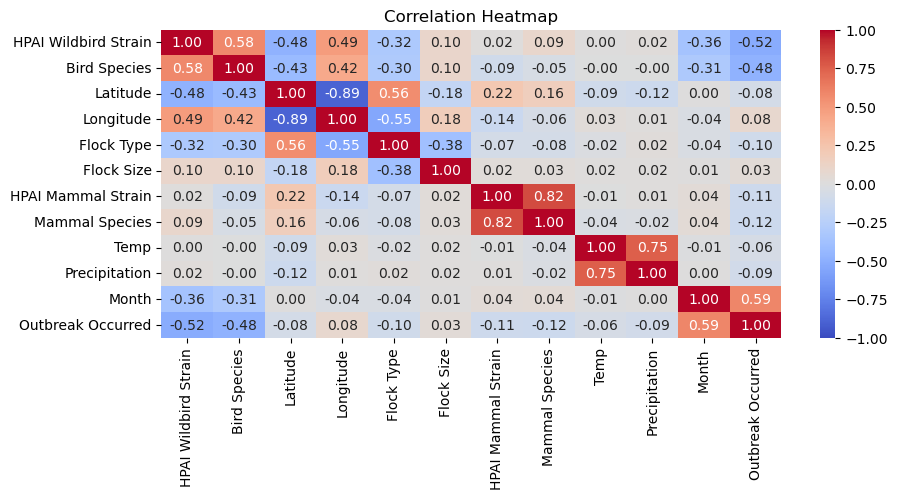

In [1034]:
# Plot the correlation

plt.figure(figsize=(10, 4))
sns.heatmap(correlation_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

# Key Observations from the Correlation Matrix:

Outbreak Risk has positive correlation with Month (0.59), indicating that the month (likely seasonality) plays a significant role in predicting the outbreaks.

HPAI Mammal Strain and Mammal Species have a high positive correlation (0.891854), which suggests that that specific mammal species are more prone to certain HPAI strains.

Flock Type and Latitude have a moderate positive correlation (0.57), indicating that certain types of flocks might be located at specific latitudes.

The HPAI Strain_x (Wild bird strain) has a moderate positive correlation with the Longitude which means certain bird species are specific to that longitudinal locations. 



Text(0.5, 1.0, 'Distribution of Month')

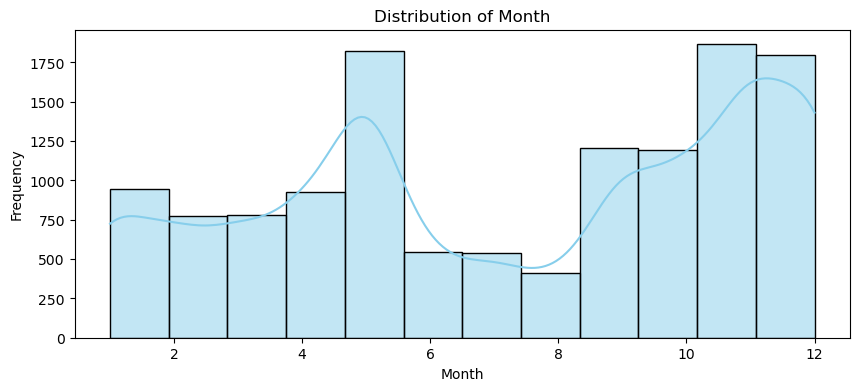

In [1035]:
# Plot the month distribution
plt.figure(figsize=(10,4))  
sns.histplot(correlation_df[correlation_df['Month'] != 0]['Month'],bins=12, kde=True,color="skyblue")
plt.xlabel("Month")
plt.ylabel("Frequency")
plt.title("Distribution of Month")

# Data Splitting

In [1036]:
# Split the training testing data
X=correlation_df.copy().drop(columns='Outbreak Occurred')
y=correlation_df['Outbreak Occurred']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=0.3)

In [1037]:
X_train.shape

(10362, 11)

In [1038]:
X_test.shape

(4441, 11)

# Data Scaling

In [1039]:
# Use Standard Scaler for scaling the numerical data

scaler=StandardScaler()
X_train_scaled =scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled

array([[ 1.32805661,  1.23563435, -0.22014178, ...,  0.17049864,
        -0.40209175, -1.49258427],
       [-1.0965897 , -1.61800779,  0.73824342, ...,  0.1940236 ,
        -0.02746302,  0.88697112],
       [ 1.32805661,  1.23563435, -2.30726883, ...,  0.17049864,
        -0.40209175,  1.3628822 ],
       ...,
       [ 0.35819809, -0.08975394,  0.53384361, ..., -0.24706941,
        -1.01841642,  0.88697112],
       [ 1.32805661,  1.23563435, -2.30726883, ...,  0.17049864,
        -0.40209175,  0.64901558],
       [-1.0965897 , -0.60368002,  0.30719538, ..., -0.24706941,
        -1.01841642,  0.64901558]])

# Model and fit the data to Logistic regression

In [1040]:
# Build logistic regression model

from sklearn.linear_model import LogisticRegression

logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train_scaled, y_train)


LogisticRegression()

In [1041]:
# Score the model
print(f"Training Data Score: {logistic_regression_model.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {logistic_regression_model.score(X_test_scaled, y_test)}")

Training Data Score: 0.9988419224088014
Testing Data Score: 0.9986489529385274


In [1042]:
# Make predictions on the test data
predictions = logistic_regression_model.predict(X_test_scaled)

# Create a confusion matrix
print(confusion_matrix(y_test, predictions, labels = [1,0]))

[[3808    0]
 [   6  627]]


In [1043]:
# R2 Score

from sklearn.metrics import r2_score

r2_value = r2_score(y_test, predictions)
print("R2 Score :",r2_value)

R2 Score : 0.9889456967621172


In [1044]:
# Create a classification report
print(classification_report(y_test, predictions, labels = [1, 0]))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      3808
           0       1.00      0.99      1.00       633

    accuracy                           1.00      4441
   macro avg       1.00      1.00      1.00      4441
weighted avg       1.00      1.00      1.00      4441



In [1045]:
# Calculate the balanced accuracy score
print(balanced_accuracy_score(y_test, predictions))

0.9952606635071091


# Random Forest model

In [1046]:
# Train a Random Forest model

from sklearn.ensemble import RandomForestClassifier

rf_model=RandomForestClassifier(random_state=1,n_estimators=500).fit(X_train_scaled,y_train)

In [1047]:
# Evaluate the model
print(f'Training Score: {rf_model.score(X_train_scaled, y_train)}')
print(f'Testing Score: {rf_model.score(X_test_scaled, y_test)}')

Training Score: 1.0
Testing Score: 1.0


In [1048]:
# Get the feature importance array
feature_importances = rf_model.feature_importances_

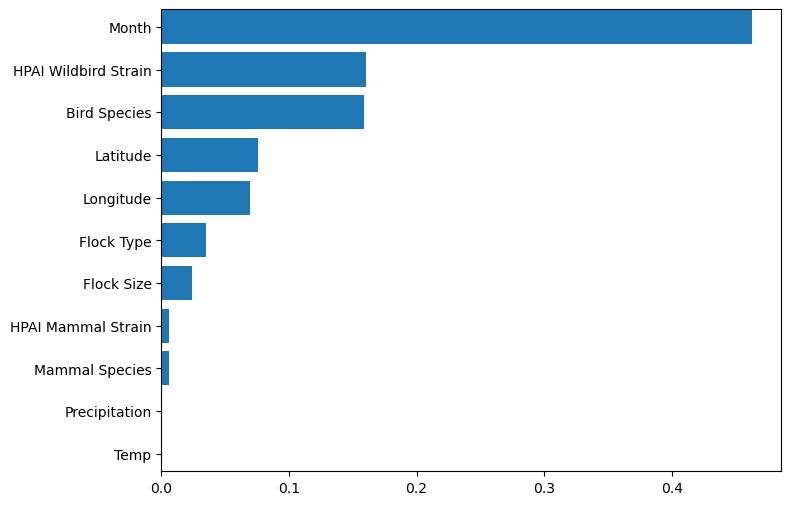

In [1049]:
# Plot the feature importances
features = sorted(zip(X.columns, feature_importances), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()

fig.set_size_inches(8,6)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

plt.show()

In [1050]:
# Make predictions on the test data
predictions1 = rf_model.predict(X_test_scaled)

# Create a confusion matrix
print(confusion_matrix(y_test, predictions1, labels = [1,0]))

[[3808    0]
 [   0  633]]


In [1051]:
# Create a classification report
print(classification_report(y_test, predictions1, labels = [1, 0]))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      3808
           0       1.00      1.00      1.00       633

    accuracy                           1.00      4441
   macro avg       1.00      1.00      1.00      4441
weighted avg       1.00      1.00      1.00      4441



### Extra Trees Classifier

In [1052]:
# Import an Extremely Random Trees classifier
from sklearn.ensemble import ExtraTreesClassifier

In [1053]:
# Train the ExtraTreesClassifier model
etc_model = ExtraTreesClassifier(random_state=1).fit(X_train_scaled, y_train)

# Evaluate the model
print(f'Training Score: {etc_model.score(X_train_scaled, y_train)}')
print(f'Testing Score: {etc_model.score(X_test_scaled, y_test)}')

Training Score: 1.0
Testing Score: 0.9995496509795091


### Gradient Boosting Classifier

In [1054]:
# Import Gradient Boosting classifier
from sklearn.ensemble import GradientBoostingClassifier

In [1055]:
gbc_model=GradientBoostingClassifier(random_state=1).fit(X_train_scaled,y_train)

# Evaluate the model
print(f'Training Score: {gbc_model.score(X_train_scaled, y_train)}')
print(f'Testing Score: {gbc_model.score(X_test_scaled, y_test)}')

Training Score: 1.0
Testing Score: 1.0


## Random Undersampling

In [1056]:
# Instantiate the RandomUnderSampler instance
rus = RandomUnderSampler(random_state=1)

# Fit the data to the model
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)


In [1057]:
# Check the sample counts
y_resampled.value_counts()

Outbreak Occurred
0    1367
1    1367
Name: count, dtype: int64

In [1058]:
# Instantiate an initial RamdonForestClassifier instance
rfc_resample_model = RandomForestClassifier()

# Fit the initial model based the training data
rfc_resample_model.fit(X_resampled, y_resampled)

RandomForestClassifier()

In [1059]:
# Make predictions using the model based on the resampled data
y_pred_resampled = rfc_resample_model.predict(X_test)

In [1060]:
# Print classification report for resampled data

print(classification_report(y_test, y_pred_resampled, labels = [1, 0]))
#print(classification_report(y_test, predictions1, labels = [1, 0]))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      3808
           0       1.00      1.00      1.00       633

    accuracy                           1.00      4441
   macro avg       1.00      1.00      1.00      4441
weighted avg       1.00      1.00      1.00      4441

